In [1]:
import matplotlib.pyplot as plt
import numpy as np
import py21cmfast as p21c
import logging, os
from datetime import datetime

## Set logger to log caching activity

In [2]:
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

## Reset cache location 

In [3]:
p21c.config['direc'] = '/lustre/aoc/projects/hera/wchin/21cmFAST-cache'

## Colorbar function

In [4]:
def colorbar(mappable, plot_color='white'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.ylabel(f'Neutral Fraction, $x_{{HI}}$', color=plot_color)
    plt.tick_params(color=plot_color, labelcolor=plot_color)
    plt.sca(last_axes)
    
    ax.tick_params(color=plot_color, labelcolor=plot_color)
    
#     for spine in ax.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
        
#     for spine in fig.spines.values():  # figure spine color
#         spine.set_edgecolor(plot_color)
    
    return cbar

## Cosmological Parameters (Default is used when no input is specified)

In [5]:
cosmo_params = p21c.CosmoParams()

## User Parameters, like box length, number of voxels (i.e. resolution) etc.

In [6]:
BOX_LEN=301  # 300, 301
HII_DIM=301  # 450, 301

user_params = p21c.UserParams(
    BOX_LEN=BOX_LEN,  # Box length in Mpc
    DIM=4*HII_DIM,      # Number of Voxels for hight resolution 
    HII_DIM=HII_DIM,  # Number of Voxels for low resolution 
    N_THREADS=os.cpu_count()
)

## Creating initial conditions box

In [7]:
start_time = datetime.now()
print(f'Excution qued at {start_time}')

init_cond = p21c.initial_conditions(
    cosmo_params=cosmo_params,
    user_params=user_params,
    direc='/lustre/aoc/projects/hera/wchin/21cmFAST-cache'
)

end_time = datetime.now()
execution_time = end_time - start_time
print(f'Execution completed at {end_time}')
print(f'Execution time = {execution_time}')

Excution qued at 2020-12-31 18:23:05.263855


2020-12-31 18:37:44,712 | INFO | Existing init_boxes found and read in (seed=230806296593).


Execution completed at 2020-12-31 18:37:45.617910
Execution time = 0:14:40.354055


# Ionized box

In [8]:
illustration_box = p21c.ionize_box(
    redshift=6.5, 
    init_boxes=init_cond,
).xH_box

2020-12-31 18:37:48,222 | INFO | Existing z=6.5 ionized boxes found and read in (seed=230806296593).


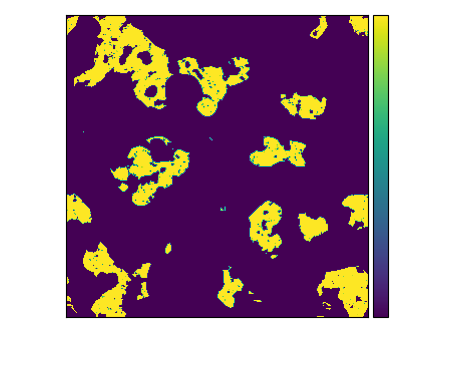

In [9]:
plt.figure(dpi=100)
color='w'
im = plt.imshow(
    illustration_box[150, :, :], 
    extent=(0,np.shape(illustration_box)[1],0,np.shape(illustration_box)[2]), 
    vmin=0, 
    vmax=1, 
    origin='lower'
)
plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

## Friends of friends method

https://tools21cm.readthedocs.io/examples/tutorials.html#Bubble-size-distribution

In [10]:
import sys
import skimage

def fof(data, xth=0.5, connectivity=1):
    """
    Determines the sizes using the friends-of-friends approach.
    It assumes the length of the grid as the linking length.

    Parameters
    ----------
    data: ndarray 
        The array containing the input data
    xth: float 
        The threshold value (Default: 0.5)

    Returns
    -------
    map: ndarray
        array with each regions of interest label
    sizes: list
        all the sizes
        
    1-connectivity      2-connectivity
          [ ]           [ ]  [ ]  [ ]
           |               \  |  /
     [ ]--[x]--[ ]      [ ]--[x]--[ ]
           |               /  |  \
          [ ]           [ ]  [ ]  [ ]
      
    """
    use_skimage=True
    t1 = datetime.now()
    data = (data>=xth)  # creating binary box
    if 'skimage' in sys.modules and use_skimage:  # use skimage if installed
        from skimage import morphology
        out_map = morphology.label(data, connectivity=connectivity)  # box with neutral regions labelled
        elements, size_list = np.unique(out_map, return_counts=True)
        size_list = size_list[1:]  # first entry corresponds to background
    else: out_map, size_list = FoF_search(data, xth)
    t2 = datetime.now()
    runtime = (t2-t1).total_seconds()/60

    print("Program runtime: %f minutes." %runtime)
    print("The output is a tuple containing output-map and volume-list array respectively.")

    return out_map, size_list

In [11]:
def reduceResolution(data, rows, cols, deps):
    from skimage.transform import resize
    return resize(data, (rows, cols, deps), mode='constant')
#     return data.reshape(rows, data.shape[0]//rows, cols, data.shape[1]//cols, deps, data.shape[2]//deps).sum(axis=1).sum(axis=2).sum(axis=3)

In [12]:
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

In [13]:
newDIM = 30
ap = np.round(normalize(reduceResolution(illustration_box, newDIM, newDIM, newDIM)))
labeled_ap, _ = fof(ap)

Program runtime: 0.017693 minutes.
The output is a tuple containing output-map and volume-list array respectively.


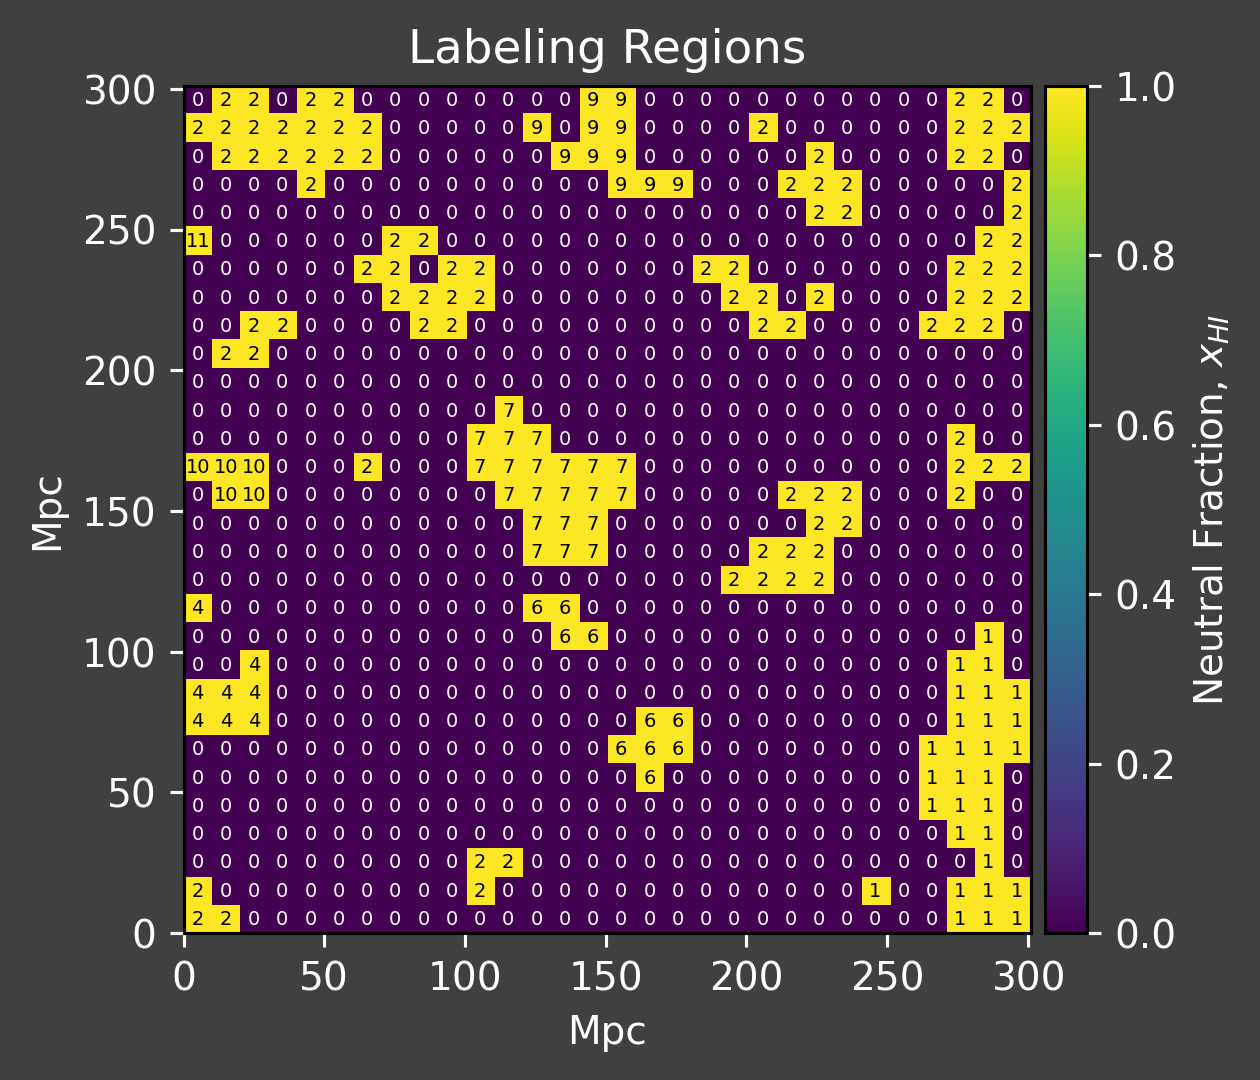

In [36]:
color='w'
z = 2  # 2

plt.figure(dpi=280.5, facecolor='#404040')
im = plt.imshow(
    ap[z, :, :],
    extent=(0., BOX_LEN, 0., BOX_LEN),
    vmin=np.min(ap[z]), 
    vmax=np.max(ap[z]), 
    origin='lower'
)

cmap = plt.get_cmap('gray')
colors = cmap(np.linspace(0, 1, 2))    
    
edges = np.linspace(0., BOX_LEN, newDIM+1)
ind = 0.5 * (edges[:-1] + edges[1:])

for i in range(newDIM):
    for j in range(newDIM):
        plt.text(
            x=ind[i], 
            y=ind[j], 
            s=labeled_ap[z, j, i], 
            va='center', 
            ha='center', 
            c=colors[int(np.logical_not(ap[z, j, i]))], 
            fontsize=5
        )

plt.tick_params(color=color, labelcolor=color)
colorbar(im)
plt.title('Labeling Regions', color=color)
plt.xlabel('Mpc', color=color)
plt.ylabel('Mpc', color=color)
plt.show()

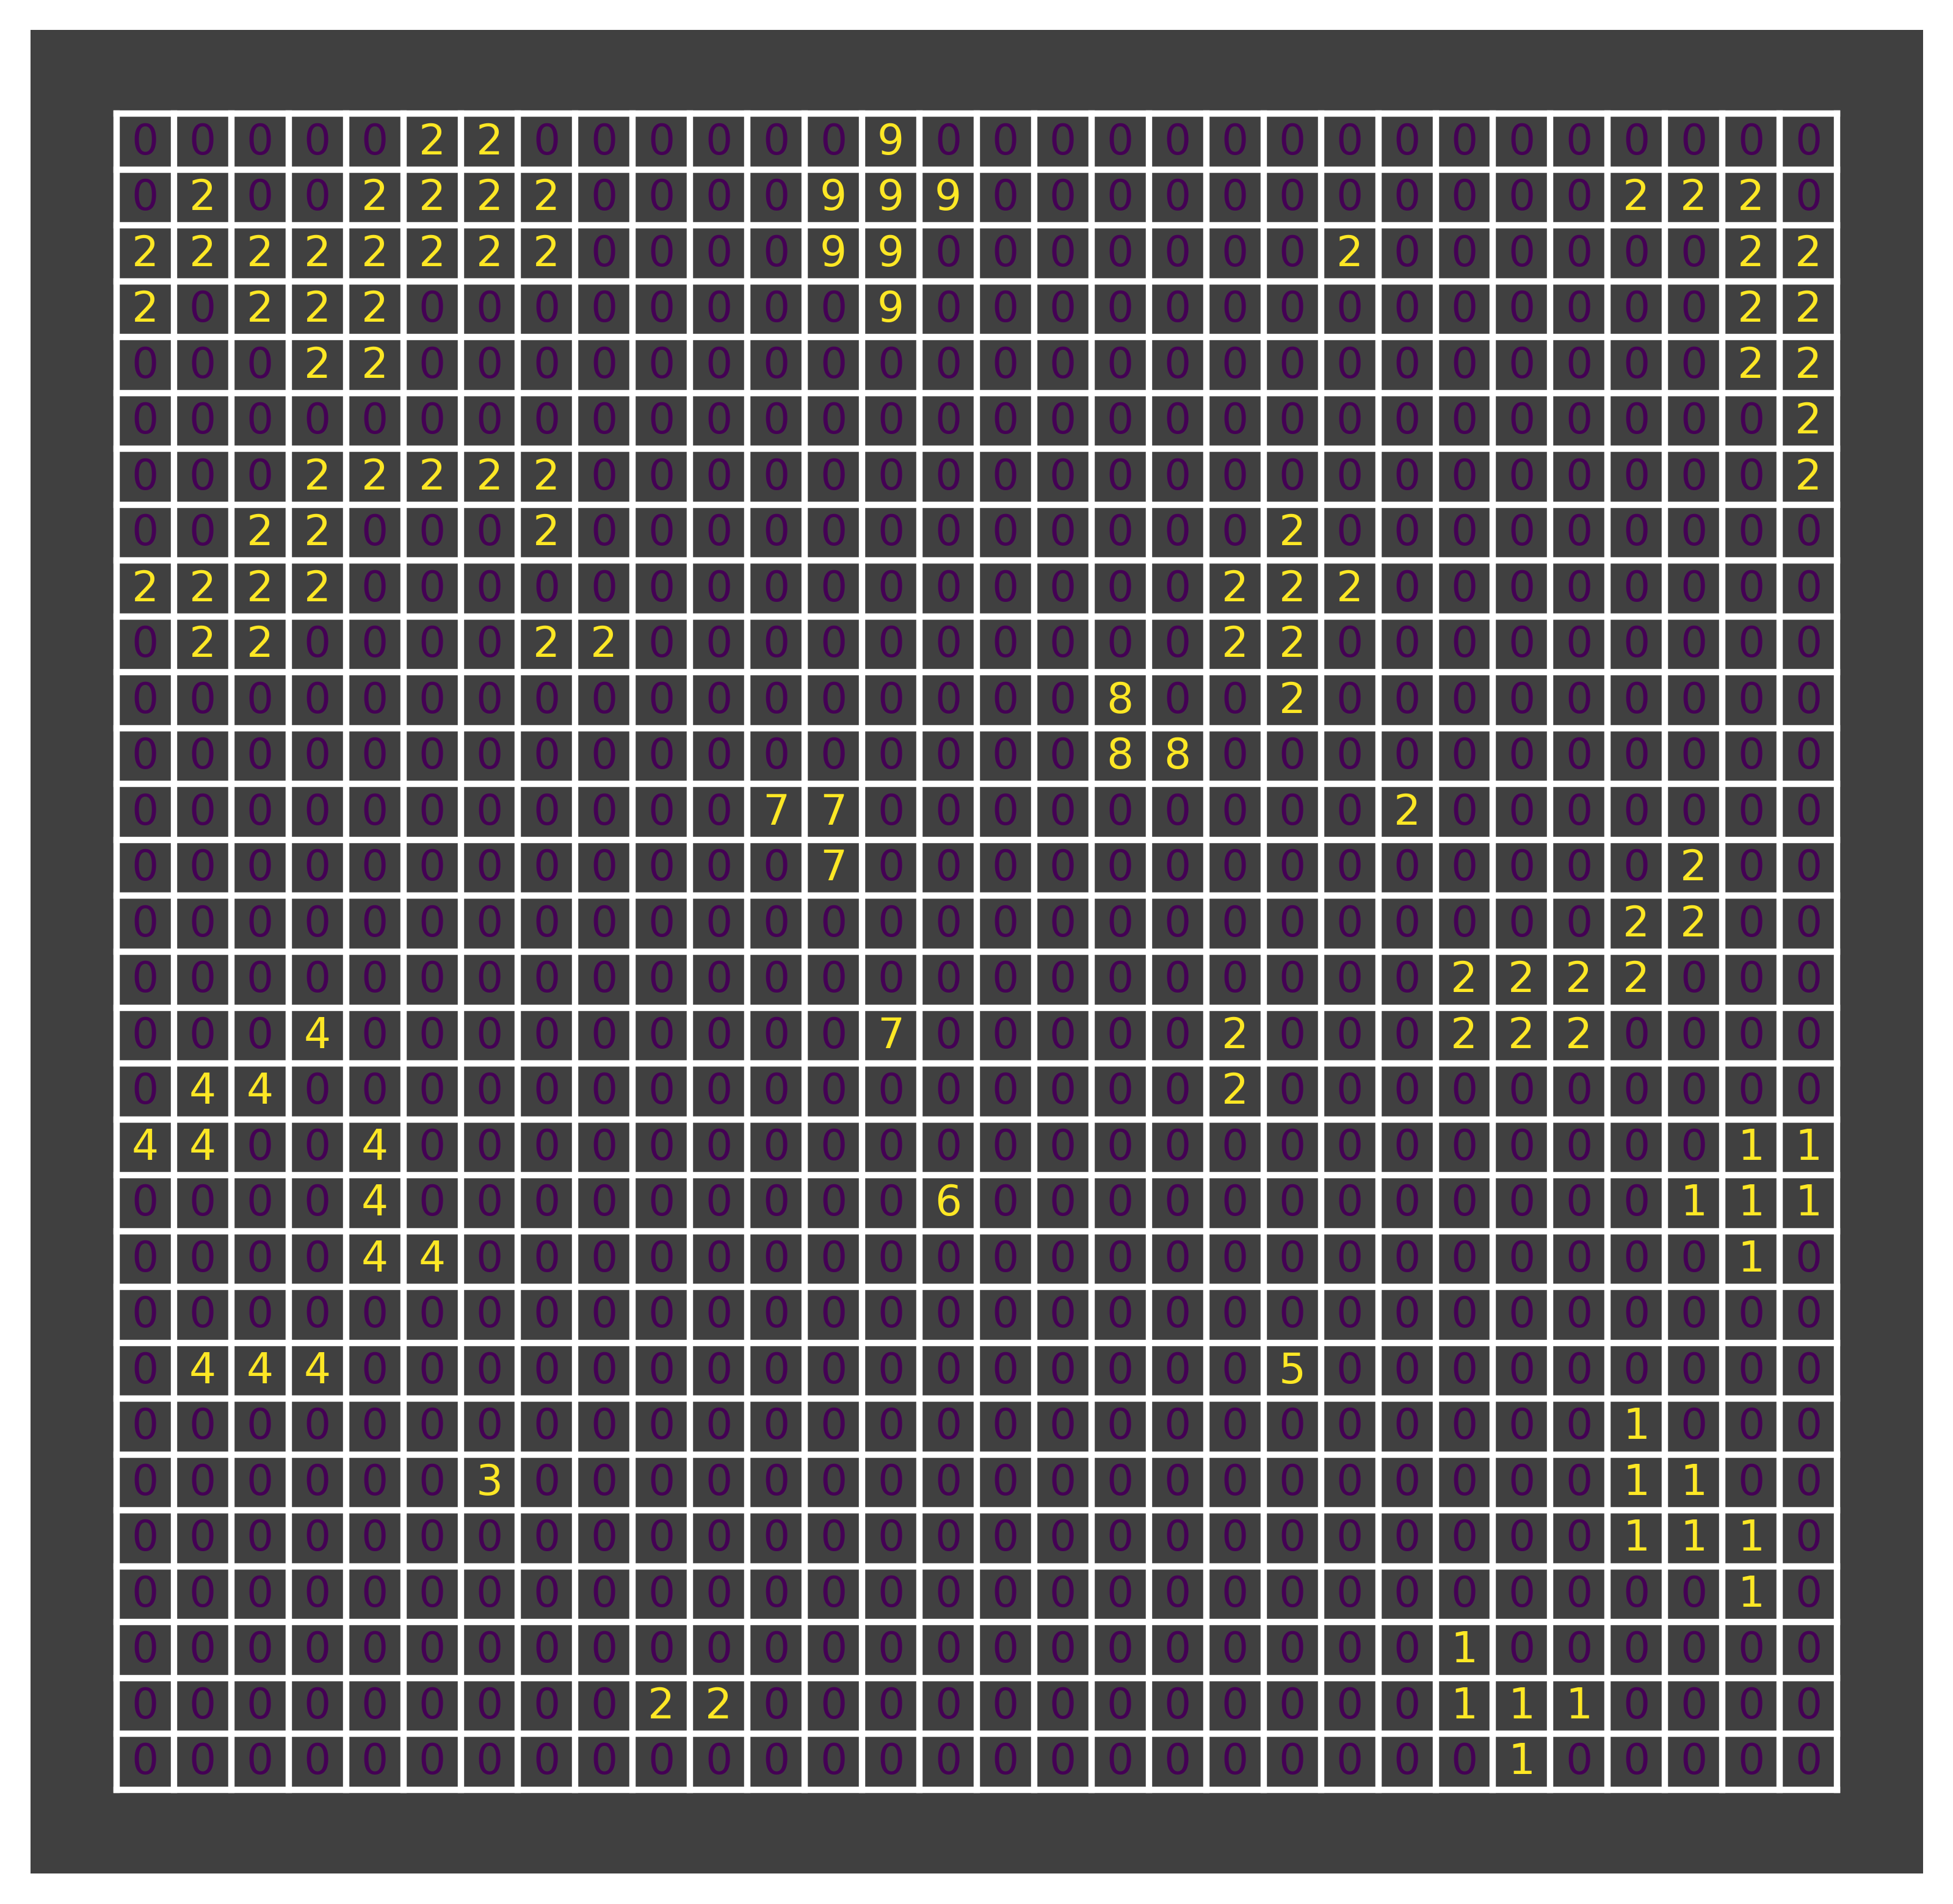

In [15]:
from skimage.morphology import label
labeled_ap = label(ap)

x_halves = np.arange(newDIM+1) - 0.5
y_halves = np.arange(newDIM+1) - 0.5

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 2))

fig = plt.figure(dpi=500, figsize=(8, 8))
ax = fig.gca()
ax.set_facecolor('#404040')
plt.xticks([])
plt.yticks([])
for spine in ax.spines.values():  # figure color
    spine.set_visible(False)
for i in range(len(x_halves)):
    plt.plot([x_halves[i]]*2, [np.min(y_halves), np.max(y_halves)], 'w')
    plt.plot([np.min(x_halves), np.max(x_halves)], [y_halves[i]]*2, 'w')
    
def text(x, y, s, c):
    plt.text(x=x, y=y, s=s, va='center', ha='center', c=colors[c])
    
for i in range(newDIM):
    for j in range(newDIM):
        text(i, j, labeled_ap[0, j, i], int(labeled_ap[0, j, i]!=0))